<a href="https://colab.research.google.com/github/iitcybersecurity/RealWorldVideoAnomalyDetection/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
# Video frames resolution BGR
FRAME_SIZES = (240, 320, 3)
PRETRAINED_INPUT_SIZE = (224, 224, 3)
N_COCO_CLASSES = 80
N_CRIME_CLASSES = 13
LSTM_UNITS = 128
C3D_INPUT_SIZE = (16, 112, 112, 3)

# supervised training
N_SUPERVISED_CLASSES = 7
CLASSES = ["Arrest", "Assault", "Burglary", "Robbery", "Stealing", "Vandalism", "Normal_Videos_event"]
BINARY_CLASSES = ["Normal", "Anomaly"]

#Models

##YOLOv4

In [ ]:
import pandas as pd
COCO_CLASSES = pd.read_csv("coco.names", header=None)[0].to_list()

In [ ]:
import cv2
from yolov4.tf import YOLOv4

yolo = YOLOv4()

yolo.config.parse_names("coco.names")
yolo.config.parse_cfg("yolov4.cfg")

yolo.make_model()
yolo.load_weights("pretrained_coco.weights", weights_type="yolo")
yolo.summary(summary_type="yolo")
yolo.summary()

In [ ]:
import numpy as np
from collections import Counter

def yolov4_detect_bag_of_objects(img, network, confidence_threshold = 0.5, n_classes = len(COCO_CLASSES)):
  '''
  Input: RGB image, network, min_confidence 
  Output: detections -> Dim(-1, (x, y, w, h, cls_id, prob)), bag_of_objects
  '''

  detections = yolo.predict(img, confidence_threshold)

  # array with objects frequency 
  bag_of_objects = np.zeros(n_classes)
  count = Counter([obj[4] for obj in detections])

  for obj in count:
    bag_of_objects[int(obj)] = count[obj]

  return detections, bag_of_objects

##CNN 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.layers import Dropout, concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from keras.applications import resnet 

# to correctly preprocess img need to be RGB
# resnet.preprocess_input(img)

def build_cnn_model(n_classes = 2, 
                    input_size = PRETRAINED_INPUT_SIZE, 
                    pretrained_network = ResNet50,
                    optical_flow = True,
                    bag_of_objects = True,
                    show_summary = False):

  pretrained_base_frame = pretrained_network(weights='imagenet', include_top=False, pooling='avg', input_shape=input_size)

  pretrained_base_frame_inp = pretrained_base_frame.input
  pretrained_base_frame_out = pretrained_base_frame.output

  pretrained_base_frame.layers[0]._name = "input_frame"
  for layer in pretrained_base_frame.layers[1:-1]:
      layer._name = layer.name + str("_frame")
  pretrained_base_frame.layers[-1]._name = "global_avg_pooling_frame"

  concatenated_out = [pretrained_base_frame_out]
  concatenated_inp = [pretrained_base_frame_inp]

  pretrained_base_opt_flow = None
  if optical_flow:
    pretrained_base_opt_flow = pretrained_network(weights='imagenet', include_top=False, pooling='avg', input_shape=input_size)

    pretrained_base_opt_flow_inp = pretrained_base_opt_flow.input
    pretrained_base_opt_flow_out = pretrained_base_opt_flow.output

    pretrained_base_opt_flow.layers[0]._name = "input_opt_flow"
    for layer in pretrained_base_opt_flow.layers[1:-1]:
        layer._name = layer.name + str("_opt_flow")
    pretrained_base_opt_flow.layers[-1]._name = "global_avg_pooling_opt_flow"

    concatenated_out.append(pretrained_base_opt_flow_out)
    concatenated_inp.append(pretrained_base_opt_flow_inp)

  if bag_of_objects:
    bag_of_objects_input = keras.Input(N_COCO_CLASSES, name="input_bag_of_objects")
    concatenated_out.append(bag_of_objects_input)
    concatenated_inp.append(bag_of_objects_input)


  if bag_of_objects or optical_flow:
    merged = concatenate(concatenated_out, name="concat_layer")
    merged = Dense(4096, activation="relu", name = "fc1")(merged)
  else:
    merged = Dense(4096, activation="relu", name = "fc1")(pretrained_base_frame_out)

  merged = Dropout(0.5, name = "drop1")(merged)
  merged = Dense(4096, activation="relu", name = "fc2")(merged)
  merged = Dropout(0.5, name = "drop2")(merged)
  merged = Dense(n_classes, activation='softmax', name = "classes")(merged)

  CNN_classificator = Model(concatenated_inp, merged, name = "CNN_classificator")

  if show_summary:
    CNN_classificator.summary()

  return CNN_classificator, pretrained_base_frame, pretrained_base_opt_flow

##Pretrained C3D (sports 1M)

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, concatenate
from keras.layers.convolutional import Conv3D, MaxPooling3D, ZeroPadding3D, Conv1D, MaxPooling1D
from tensorflow import keras

# From: https://github.com/aslucki/C3D_Sport1M_keras

def build_c3d_model(n_classes, input_shape, c3d_weight_path, dim_bag_of_objects = None, show_summary=False):
  """
  Construct c3d model and loads weigths, if dim_bag_of_objects not None creates a joint fusion model 
  """

  c3d_base_model = Sequential()
  c3d_base_model.add(Conv3D(64, (3, 3, 3), activation='relu',
                    padding='same', name='conv1',
                    input_shape=input_shape))
  c3d_base_model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2),
                          padding='valid', name='pool1'))
  # 2nd layer group
  c3d_base_model.add(Conv3D(128, (3, 3, 3), activation='relu',
                    padding='same', name='conv2'))
  c3d_base_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                          padding='valid', name='pool2'))
  # 3rd layer group
  c3d_base_model.add(Conv3D(256, (3, 3, 3), activation='relu',
                    padding='same', name='conv3a'))
  c3d_base_model.add(Conv3D(256, (3, 3, 3), activation='relu',
                    padding='same', name='conv3b'))
  c3d_base_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                          padding='valid', name='pool3'))
  # 4th layer group
  c3d_base_model.add(Conv3D(512, (3, 3, 3), activation='relu',
                    padding='same', name='conv4a'))
  c3d_base_model.add(Conv3D(512, (3, 3, 3), activation='relu',
                    padding='same', name='conv4b'))
  c3d_base_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                          padding='valid', name='pool4'))
  # 5th layer group
  c3d_base_model.add(Conv3D(512, (3, 3, 3), activation='relu',
                    padding='same', name='conv5a'))
  c3d_base_model.add(Conv3D(512, (3, 3, 3), activation='relu',
                    padding='same', name='conv5b'))
  c3d_base_model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
  c3d_base_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                          padding='valid', name='pool5'))
  c3d_base_model.add(Flatten(name='flatten_c3d'))
  # FC layers group
  c3d_base_model.add(Dense(4096, activation='relu', name='fc6'))
  c3d_base_model.add(Dropout(.5))
  c3d_base_model.add(Dense(4096, activation='relu', name='fc7'))
  c3d_base_model.add(Dropout(.5))
  c3d_base_model.add(Dense(487, activation='softmax', name='fc8'))

  # Load weights
  c3d_base_model.load_weights(c3d_weight_path)

  # Custom part
  if dim_bag_of_objects is None:
    merged = Dense(4096, activation="relu", name = "fc1")(c3d_base_model.get_layer('flatten_c3d').output)
  else:      
    bag_model = Sequential()
    bag_model.add(keras.Input(shape=(16,N_COCO_CLASSES), name="input_bag_of_objects"))
    bag_model.add(Conv1D(80, 3, activation='relu', name="conv1d_1"))
    bag_model.add(MaxPooling1D(2, name="max_pool_1"))
    bag_model.add(Conv1D(80, 3, activation='relu', name="conv1d_2"))
    bag_model.add(MaxPooling1D(2, name="max_pool_2"))
    bag_model.add(Flatten(name = "flatten_1d"))
    merged = concatenate([c3d_base_model.get_layer('flatten_c3d').output, bag_model.output], name="concat_layer")
    merged = Dense(4096, activation="relu", name = "fc1")(merged)

  merged = Dropout(0.5, name = "drop1")(merged)
  merged = Dense(4096, activation="relu", name = "fc2")(merged)
  merged = Dropout(0.5, name = "drop2")(merged)
  merged = Dense(n_classes, activation='softmax', name = "classes")(merged)

  if dim_bag_of_objects is None:
    c3d_classificator = Model(c3d_base_model.input, merged, name = "c3d_classificator")
  else:
    c3d_classificator = Model([c3d_base_model.input,bag_model.input], merged, name = "c3d_classificator")

  if show_summary:
    c3d_classificator.summary()

  return c3d_classificator, c3d_base_model

#Taining

##Setup

In [ ]:
N_SUPERVISED_CLASSES = 7
CLASSES = ["Arrest", "Assault", "Burglary", "Robbery", "Stealing", "Vandalism", "Normal_Videos_event"]

In [ ]:
import pandas as pd
VIDEOS_PATH = "Data/Videos"

In [ ]:
train_split = pd.read_csv("Data/framebyframe_annotations/Train_split_AD.txt", header=None)
print(train_split)
test_val_split = pd.read_csv("Data/framebyframe_annotations/Test_split_AD.txt", header=None)
print(test_val_split)

# reservations odd rows, even rows deleted
test_split=test_val_split[test_val_split.index%2==0]
print(test_split)

# retained even rows, delete odd lines
val_split=test_val_split[test_val_split.index%2==1]
print(val_split)

1.   **Track ID** All rows with the same ID belong to 
the same path.
2.   **xmin** The top left x-coordinate of the bounding box.
3.   **ymin** The top left y-coordinate of the bounding box.
4.   **xmax** The bottom right x-coordinate of the bounding box.
5.   **ymax** The bottom right y-coordinate of the bounding box.
6.   **frame** The frame that this annotation represents.
7.   **lost** If 1, the annotation is outside of the view screen.
8.   **occluded** If 1, the annotation is occluded.
9.   **generated** If 1, the annotation was automatically interpolated.
10.  **label** The label for this annotation, enclosed in quotation marks.

!!! Frames contains anomalies only if **lost** is 0 !!!

###Utils

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  '''
  Plots Training and validation loss and accuracy graphs
  '''
  acc = history['accuracy']
  val_acc = history['val_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, '--b.', label='Training accuracy')
  plt.plot(epochs, val_acc, '--r.', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.grid(color='grey', which='major', axis='y', linestyle='--')

  plt.figure()

  plt.plot(epochs, loss, '--b.', label='Training loss')
  plt.plot(epochs, val_loss, '--r.', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.grid(color='grey', which='major', axis='y', linestyle='--')

  plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
def plot_roc_curve(test_labels, models_test_predictions, model_names):
  '''
  Plot a roc curve for every model predictions 
  '''
  color_idxs = np.linspace(0, 1, len(model_names))
  for test_predictions, name, color_idx in zip(models_test_predictions, model_names, color_idxs):
    fpr, tpr, _ = roc_curve(test_labels, test_predictions)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=plt.cm.winter(color_idx),
            lw=2, label= name + ' (area = %0.3f)' % roc_auc)
    
  plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
import smtplib, ssl
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

def send_email(sender_email, password, receiver_emai, subject="Training INFO", text="", port = 465, smtp_server = "smtp.gmail.com" ):

  message = MIMEMultipart("alternative")
  message["Subject"] = subject
  message["From"] = sender_email
  message["To"] = receiver_email

  part1 = MIMEText(text, "plain")
  message.attach(part1)

  context = ssl.create_default_context()
  with smtplib.SMTP_SSL(smtp_server, port, context=context) as server:
      server.login(sender_email, password)
      server.sendmail(
          sender_email, receiver_email, message.as_string()
      )

##CNN

###Preprocessing

Extract preprocessed frames and optical flows, others than bag of objects in frames and class lables 

In [ ]:
import cv2
import numpy as np
from IPython.display import clear_output 
from time import sleep
from collections import Counter
from sklearn.preprocessing import Normalizer
from tqdm.notebook import tqdm
import math
import os
import h5py
import _thread
import pickle
import gc

def video_preprocessing(videos_split,
                        input_size = PRETRAINED_INPUT_SIZE,
                        anomalous_sample_rate = 10,
                        normal_sample_rate = 30,
                        store_one_by_one = False,
                        path = None,
                        not_consider_normal = True,
                        store_one_video_at_time=False,
                        object_detector = yolo):

  attempt = 0 # max 100 attempts to avoid infinite loops
  while True:
    video = videos_split[0]
    try:
      index = 0
      ignore = False
      not_ignore_count = 0
      first = True

      for video, video_idx in zip(videos_split[0],range(0,len(videos_split))):

        anomalous_video = True if "Normal_Videos" not in video else False
        normal_video = not anomalous_video

        if anomalous_video:
          annotations = pd.read_csv("Data/framebyframe_annotations/annotations/"+video+".txt", header=None,sep=" ")
          video_class = annotations.iloc[:,-1][0]
          frame_annotations = annotations[annotations[6] != 1][5].tolist()
        else:
          video_class = "Normal_Videos_event"

        # Capture video from file or link
        if anomalous_video:
          video_path = "Data/Videos/" + video_class + "/" + video.strip() + "_x264.mp4"
        else:
          video_path = "Data/Videos/Training_Normal_Videos_Anomaly/" + video.strip() + "_x264.mp4"

        print("Video: " + str(video_path))

        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # read first frame
        _, frame1 = cap.read() # BGR
        prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
        ok = True
        hsv = np.zeros_like(frame1)
        hsv[...,1] = 255

        flow = None

        # Loop the video
        for frame_idx in tqdm(range(1, total_frames)):

          # Using different sample rate for normal and anomalous videos
          sample_rate = normal_sample_rate if (normal_video or frame_idx not in frame_annotations) else anomalous_sample_rate
          _, frame2 = cap.read()

          if frame_idx % sample_rate == 0:

            if anomalous_video and frame_idx in frame_annotations:
              # assign correct class to frames in anomalous videos
              frame_class = video_class
            else:
              frame_class = "Normal_Videos_event"

            # class in one_hot_encoding
            one_hot_class = np.zeros(N_SUPERVISED_CLASSES)
            one_hot_class[CLASSES.index(frame_class)] = 1

            # read next frame
            next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

            # calculate optical flow using previous and next frames (using default params)
            # 6th parameter: larger values increase the algorithm robustness to image noise and give more chances for fast motion detection, but yield more blurred motion field
            flow = cv2.calcOpticalFlowFarneback(prvs, next, flow, 0.5, 3, 15, 3, 5, 1.2, 0)

            # convert flow to rgb 
            mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
            hsv[...,0] = ang*180/np.pi/2
            hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
            rgb_optical_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

            prvs = next

            # objects detection
            if not not_consider_normal or (not_consider_normal and anomalous_video and frame_idx in frame_annotations) or normal_video: 
              # Skip only if not_consider_normal is true and the frame is normal in an anomalous video

              #print(video, frame_class)

              # objects detection
              frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
              _, bag_of_objects = yolov4_detect_bag_of_objects(frame2_rgb, yolo)

              # features extraction
              # preprocess_input want RGB images in input
              frame2_resized = cv2.resize(frame2_rgb, (input_size[0],input_size[1]), interpolation = cv2.INTER_AREA)
              optical_flow_resized = cv2.resize(rgb_optical_flow, (input_size[0],input_size[1]), interpolation = cv2.INTER_AREA)

              frame2_preprocessed = resnet.preprocess_input(frame2_resized).reshape(1,input_size[0],input_size[1],input_size[2])
              optical_flow_preprocessed  = resnet.preprocess_input(optical_flow_resized).reshape(1,input_size[0],input_size[1],input_size[2])
              
              if first or store_one_by_one:
                first = False
                frames_batch = np.array(frame2_preprocessed)
                optical_flows_batch = np.array(optical_flow_preprocessed)
                boos_bach = np.array(bag_of_objects)
                video_classes = np.array(one_hot_class)
              else: 
                frames_batch = np.append(frames_batch,frame2_preprocessed)
                optical_flows_batch = np.append(optical_flows_batch,optical_flow_preprocessed)
                boos_bach = np.append(boos_bach,bag_of_objects)
                video_classes = np.append(video_classes,one_hot_class)

              if store_one_by_one:

                tmp_path = f"{path}{str(video.strip())}/"

                if not os.path.exists(tmp_path):
                  os.makedirs(tmp_path)

                # faster with smaller objects
                with open(tmp_path + "preprocessing_" + str(frame_idx) + ".pkl", "wb") as f:
                  pickle.dump([frames_batch, optical_flows_batch, boos_bach, video_classes], f)
                
                # prevent memory leak
                gc.collect()

        if store_one_video_at_time:
          first = True
        
          if not os.path.exists(path):
              os.makedirs(path)

          # too large for classical numpy save
          with h5py.File(path + "preprocessing_" + str(video.strip()), 'w') as hf:
            hf.create_dataset("frames_batch",  data=frames_batch)
            hf.create_dataset("optical_flows_batch",  data=optical_flows_batch)
            hf.create_dataset("boos_bach",  data=boos_bach)
            hf.create_dataset("video_classes",  data=video_classes)
          

      # correctly reshape inputs and classes
      frames_batch = np.array(frames_batch).reshape(-1,input_size[0],input_size[1],input_size[2])
      optical_flows_batch = np.array(optical_flows_batch).reshape(-1,input_size[0],input_size[1],input_size[2])
      boos_bach = np.array(boos_bach).reshape(-1,N_COCO_CLASSES)
      video_classes = np.array(video_classes).reshape(-1,N_SUPERVISED_CLASSES)

      if not store_one_by_one and not store_one_video_at_time:

        if not os.path.exists(path):
            os.makedirs(path)

        # too large for classical numpy save
        with h5py.File(path + "preprocessing_all", 'w') as hf:
          hf.create_dataset("frames_batch",  data=frames_batch)
          hf.create_dataset("optical_flows_batch",  data=optical_flows_batch)
          hf.create_dataset("boos_bach",  data=boos_bach)
          hf.create_dataset("video_classes",  data=video_classes)
        
        return frames_batch, optical_flows_batch, boos_bach, video_classes
      return
    except Exception as ex:
      print("ERROR: " + str(ex) + " for " + str(video.strip()) + " retrying...")
      attempt += 1
      if attempt > 100:
        print("Too many errors, abort!")
        return

In [ ]:
with open("Saved/ALL_framebyframe/Train/Arrest002/preprocessing_1.pkl", "rb") as f:
  out = pickle.load(f)

In [ ]:
from threading import Thread

pool_size = 5
videos = len(train_split)

for i in range(0, videos, pool_size):

  print("---------- POOL START [{},{}]/{} ----------".format(i,i+pool_size,videos))

  pool = []
  for j in range(i, i + pool_size):
    if j < videos:
      t = Thread( target=video_preprocessing, args=(train_split[j:j+1], PRETRAINED_INPUT_SIZE, 1, 1, True, "Saved/ALL_framebyframe/Train/", False, False, yolo))
      t.start()
      pool.append(t)
  for t in pool:
    t.join()



In [ ]:
from threading import Thread

pool_size = 5
videos = len(val_split)

for i in range(0, videos, pool_size):

  print("---------- POOL START [{},{}]/{} ----------".format(i,i+pool_size,videos))

  pool = []
  for j in range(i, i + pool_size):
    if j < videos:
      t = Thread( target=video_preprocessing, args=(val_split[j:j+1], PRETRAINED_INPUT_SIZE, 1, 1, True, "Saved/ALL_framebyframe/Validation/", False, False, yolo))
      t.start()
      pool.append(t)
  for t in pool:
    t.join()

In [ ]:
from threading import Thread

pool_size = 12
videos = len(test_split)

for i in range(0, videos, pool_size):

  print("---------- POOL START [{},{}]/{} ----------".format(i,i+pool_size,videos))

  pool = []
  for j in range(i, i + pool_size):
    if j < videos:
      t = Thread( target=video_preprocessing, args=(test_split[j:j+1], PRETRAINED_INPUT_SIZE, 1, 1, False, "Saved/CNN_with_normal/Test/", False, 1, True, yolo))
      t.start()
      pool.append(t)
  for t in pool:
    t.join()

###Data Loading

In [ ]:
from threading import Thread
import h5py

class GetDataChunk(Thread):        

  def __init__(self, path):
    self.frames = None
    self.optical_flows = None
    self.boos = None
    self.classes = None
    self.path = path
    super(GetDataChunk, self).__init__()
    print("--- Thread for {} started...".format(self.path))

  def run(self):
    with h5py.File(self.path, "r") as h5f:
      self.frames = h5f["frames_batch"][()]
      self.optical_flows= h5f["optical_flows_batch"][()]
      self.boos = h5f["boos_bach"][()]
      self.classes = h5f["video_classes"][()]
      print("--- Thread for {} ended...".format(self.path))


####Trainingset Validationset

In [ ]:
import os

BASE_PATH = "Saved/CNN_preprocessing/"

# Get file-names in folders
train_videos = [name for name in os.listdir(BASE_PATH + "Train/") if os.path.isfile(os.path.join(BASE_PATH + "Train/", name))]
val_videos = [name for name in os.listdir(BASE_PATH + "Validation/") if os.path.isfile(os.path.join(BASE_PATH + "Validation/", name))]

# Only anomalies 
#train_videos = [name for name in os.listdir("Saved/Train/") if os.path.isfile(os.path.join("Saved/Train/", name)) and "Normal" not in name]
#val_videos = [name for name in os.listdir("Saved/Validation/") if os.path.isfile(os.path.join("Saved/Validation/", name)) and "Normal" not in name]

In [ ]:
import numpy as np
from time import sleep
from tqdm.notebook import tqdm

folder = BASE_PATH + "Train/"
pool_size = 12
videos = len(train_videos)
first = True

for i in tqdm(range(0, videos, pool_size)):

  print("---------- POOL START [{},{}]/{} ----------".format(i,i+pool_size,videos))

  pool = []
  for j in range(i, i + pool_size):
    if j < videos:
      sleep(0.5)
      t = t = GetDataChunk(folder+train_videos[j])
      t.start()
      pool.append(t)
  for t in pool:
    t.join()

  for t in pool:
    if first:
      train_frames = t.frames
      train_optical_flows= t.optical_flows
      train_boos = t.boos
      train_classes = t.classes
      first = False
    else:
      train_frames = np.append(train_frames,t.frames)
      train_optical_flows= np.append(train_optical_flows,t.optical_flows)
      train_boos = np.append(train_boos,t.boos)
      train_classes = np.append(train_classes,t.classes)

# correctly reshape inputs and classes
train_frames = np.array(train_frames).reshape(-1,PRETRAINED_INPUT_SIZE[0],PRETRAINED_INPUT_SIZE[1],PRETRAINED_INPUT_SIZE[2])
train_optical_flows = np.array(train_optical_flows).reshape(-1,PRETRAINED_INPUT_SIZE[0],PRETRAINED_INPUT_SIZE[1],PRETRAINED_INPUT_SIZE[2])
train_boos = np.array(train_boos).reshape(-1,N_COCO_CLASSES)
train_classes = np.array(train_classes).reshape(-1,N_SUPERVISED_CLASSES)

print(train_frames.shape)
print(train_optical_flows.shape)
print(train_boos.shape)
print(train_classes.shape)

In [ ]:
import numpy as np
from time import sleep
from tqdm.notebook import tqdm

folder = BASE_PATH + "Validation/"
pool_size = 12
videos = len(val_videos)
first = True

for i in tqdm(range(0, videos, pool_size)):

  print("---------- POOL START [{},{}]/{} ----------".format(i,i+pool_size,videos))

  pool = []
  for j in range(i, i + pool_size):
    if j < videos:
      sleep(0.5)
      t = t = GetDataChunk(folder+val_videos[j])
      t.start()
      pool.append(t)
  for t in pool:
    t.join()

  for t in pool:
    if first:
      val_frames = t.frames
      val_optical_flows= t.optical_flows
      val_boos = t.boos
      val_classes = t.classes
      first = False
    else:
      val_frames = np.append(val_frames,t.frames)
      val_optical_flows= np.append(val_optical_flows,t.optical_flows)
      val_boos = np.append(val_boos,t.boos)
      val_classes = np.append(val_classes,t.classes)

# correctly reshape inputs and classes
val_frames = np.array(val_frames).reshape(-1,PRETRAINED_INPUT_SIZE[0],PRETRAINED_INPUT_SIZE[1],PRETRAINED_INPUT_SIZE[2])
val_optical_flows = np.array(val_optical_flows).reshape(-1,PRETRAINED_INPUT_SIZE[0],PRETRAINED_INPUT_SIZE[1],PRETRAINED_INPUT_SIZE[2])
val_boos = np.array(val_boos).reshape(-1,N_COCO_CLASSES)
val_classes = np.array(val_classes).reshape(-1,N_SUPERVISED_CLASSES)

print(val_frames.shape)
print(val_optical_flows.shape)
print(val_boos.shape)
print(val_classes.shape)

####Testset

In [ ]:
import os
test_videos = [name for name in os.listdir("Saved/CNN_with_normal/Test/") if os.path.isfile(os.path.join("Saved/CNN_with_normal/Test/", name))]

# Only anomalies 
#test_videos = [name for name in os.listdir("Saved/Test/") if os.path.isfile(os.path.join("Saved/Test/", name)) and "Normal" not in name]

In [ ]:
import numpy as np
from time import sleep

folder = "Saved/CNN_with_normal/Test/"
pool_size = 12
videos = len(test_videos)
first = True

for i in range(0, videos, pool_size):

  print("---------- POOL START [{},{}]/{} ----------".format(i,i+pool_size,videos))

  pool = []
  for j in range(i, i + pool_size):
    if j < videos:
      sleep(0.5)
      t = t = GetDataChunk(folder+test_videos[j])
      t.start()
      pool.append(t)
  for t in pool:
    t.join()

  for t in pool:
    if first:
      test_frames = t.frames
      test_optical_flows= t.optical_flows
      test_boos = t.boos
      test_classes = t.classes
      first = False
    else:
      test_frames = np.append(test_frames,t.frames)
      test_optical_flows= np.append(test_optical_flows,t.optical_flows)
      test_boos = np.append(test_boos,t.boos)
      test_classes = np.append(test_classes,t.classes)

# correctly reshape inputs and classes
test_frames = np.array(test_frames).reshape(-1,PRETRAINED_INPUT_SIZE[0],PRETRAINED_INPUT_SIZE[1],PRETRAINED_INPUT_SIZE[2])
test_optical_flows = np.array(test_optical_flows).reshape(-1,PRETRAINED_INPUT_SIZE[0],PRETRAINED_INPUT_SIZE[1],PRETRAINED_INPUT_SIZE[2])
test_boos = np.array(test_boos).reshape(-1,N_COCO_CLASSES)
test_classes = np.array(test_classes).reshape(-1,N_SUPERVISED_CLASSES)

print(test_frames.shape)
print(test_optical_flows.shape)
print(test_boos.shape)
print(test_classes.shape)

In [ ]:
## Save all for quicker loading
#with h5py.File("Saved/Train/ALL/preprocessing", 'w') as hf:
#          hf.create_dataset("frames_batch",  data=train_frames)
#          hf.create_dataset("optical_flows_batch",  data=train_optical_flows)
#          hf.create_dataset("boos_bach",  data=train_boos)
#          hf.create_dataset("video_classes",  data=train_classes)
#
## Save all for quicker loading
#with h5py.File("Saved/Validation/ALL/preprocessing", 'w') as hf:
#          hf.create_dataset("frames_batch",  data=val_frames)
#          hf.create_dataset("optical_flows_batch",  data=val_optical_flows)
#          hf.create_dataset("boos_bach",  data=val_boos)
#          hf.create_dataset("video_classes",  data=val_classes)
#
## Save all for quicker loading
#with h5py.File("Saved/Test/ALL/preprocessing", 'w') as hf:
#          hf.create_dataset("frames_batch",  data=test_frames)
#          hf.create_dataset("optical_flows_batch",  data=test_optical_flows)
#          hf.create_dataset("boos_bach",  data=test_boos)
#          hf.create_dataset("video_classes",  data=test_classes)

In [ ]:
#N_TRAIN_FRAMES = 10380
#N_VAL_FRAMES = 2201
#N_TEST_FRAMES = 2352

In [ ]:
#import os
#
## Counts number of files on each folder
#N_TRAIN_FRAMES = len([name for name in os.listdir("Saved/Train/") if os.path.isfile(os.path.join("Saved/Train/", name))])
#N_VAL_FRAMES = len([name for name in os.listdir("Saved/Validation/") if os.path.isfile(os.path.join("Saved/Validation/", name))])
#N_TEST_FRAMES = len([name for name in os.listdir("Saved/Test/") if os.path.isfile(os.path.join("Saved/Test/", name))])

In [ ]:
#print(N_TRAIN_FRAMES)
#print(N_VAL_FRAMES)
#print(N_TEST_FRAMES)

In [ ]:
import h5py
with h5py.File("Saved/Train/ALL/preprocessing", "r") as h5f:
      train_frames = h5f["frames_batch"][()]
      train_optical_flows= h5f["optical_flows_batch"][()]
      train_boos = h5f["boos_bach"][()]
      train_classes = h5f["video_classes"][()]

# correctly reshape inputs and classes
train_frames = np.array(train_frames).reshape(-1,FRAME_SIZES[0],FRAME_SIZES[1],FRAME_SIZES[2])
train_optical_flows = np.array(train_optical_flows).reshape(-1,FRAME_SIZES[0],FRAME_SIZES[1],FRAME_SIZES[2])
train_boos = np.array(train_boos).reshape(-1,N_COCO_CLASSES)
train_classes = np.array(train_classes).reshape(-1,N_SUPERVISED_CLASSES)

print(train_frames.shape)
print(train_optical_flows.shape)
print(train_boos.shape)
print(train_classes.shape)

In [ ]:
# correctly reshape inputs and classes
train_frames = np.array(train_frames).reshape(-1,FRAME_SIZES[0],FRAME_SIZES[1],FRAME_SIZES[2])
train_optical_flows = np.array(train_optical_flows).reshape(-1,FRAME_SIZES[0],FRAME_SIZES[1],FRAME_SIZES[2])
train_boos = np.array(train_boos).reshape(-1,N_COCO_CLASSES)
train_classes = np.array(train_classes).reshape(-1,N_SUPERVISED_CLASSES)

print(train_frames.shape)
print(train_optical_flows.shape)
print(train_boos.shape)
print(train_classes.shape)

In [ ]:
with h5py.File("Saved/Validation/ALL/preprocessing", "r") as h5f:
      val_frames = h5f["frames_batch"][()]
      val_optical_flows= h5f["optical_flows_batch"][()]
      val_boos = h5f["boos_bach"][()]
      val_classes = h5f["video_classes"][()]

# correctly reshape inputs and classes
val_frames = np.array(val_frames).reshape(-1,FRAME_SIZES[0],FRAME_SIZES[1],FRAME_SIZES[2])
val_optical_flows = np.array(val_optical_flows).reshape(-1,FRAME_SIZES[0],FRAME_SIZES[1],FRAME_SIZES[2])
val_boos = np.array(val_boos).reshape(-1,N_COCO_CLASSES)
val_classes = np.array(val_classes).reshape(-1,N_SUPERVISED_CLASSES)

print(val_frames.shape)
print(val_optical_flows.shape)
print(val_boos.shape)
print(val_classes.shape)

In [ ]:
with h5py.File("Saved/Test/ALL/preprocessing", "r") as h5f:
      test_frames = h5f["frames_batch"][()]
      test_optical_flows= h5f["optical_flows_batch"][()]
      test_boos = h5f["boos_bach"][()]
      test_classes = h5f["video_classes"][()]

# correctly reshape inputs and classes
test_frames = np.array(test_frames).reshape(-1,FRAME_SIZES[0],FRAME_SIZES[1],FRAME_SIZES[2])
test_optical_flows = np.array(test_optical_flows).reshape(-1,FRAME_SIZES[0],FRAME_SIZES[1],FRAME_SIZES[2])
test_boos = np.array(test_boos).reshape(-1,N_COCO_CLASSES)
test_classes = np.array(test_classes).reshape(-1,N_SUPERVISED_CLASSES)

print(test_frames.shape)
print(test_optical_flows.shape)
print(test_boos.shape)
print(test_classes.shape)

###Class Distributions

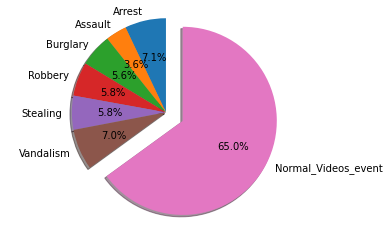

['Arrest', 'Assault', 'Burglary', 'Robbery', 'Stealing', 'Vandalism', 'Normal_Videos_event']
[684, 353, 543, 563, 566, 678, 6289]


In [ ]:
import numpy as np
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Arrest", "Assault", "Burglary", "Robbery", "Stealing", "Vandalism", "Normal_Videos_event"]
sizes = [np.count_nonzero(train_classes[:,0]),np.count_nonzero(train_classes[:,1]),np.count_nonzero(train_classes[:,2]),np.count_nonzero(train_classes[:,3]),np.count_nonzero(train_classes[:,4]),np.count_nonzero(train_classes[:,5]),np.count_nonzero(train_classes[:,6])]
explode = (0, 0, 0, 0, 0, 0, 0.2)  # only "explode" the 2nd slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()
print(labels)
print(sizes)

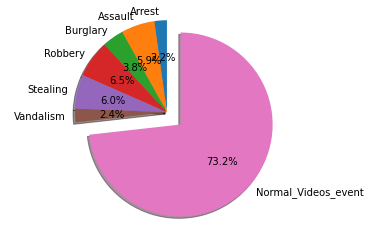

['Arrest', 'Assault', 'Burglary', 'Robbery', 'Stealing', 'Vandalism', 'Normal_Videos_event']
[45, 121, 77, 134, 122, 49, 1499]


In [ ]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Arrest", "Assault", "Burglary", "Robbery", "Stealing", "Vandalism", "Normal_Videos_event"]
sizes = [np.count_nonzero(val_classes[:,0]),np.count_nonzero(val_classes[:,1]),np.count_nonzero(val_classes[:,2]),np.count_nonzero(val_classes[:,3]),np.count_nonzero(val_classes[:,4]),np.count_nonzero(val_classes[:,5]),np.count_nonzero(val_classes[:,6])]
explode = (0, 0, 0, 0, 0, 0, 0.2)  # only "explode" the 2nd slice

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()
print(labels)
print(sizes)

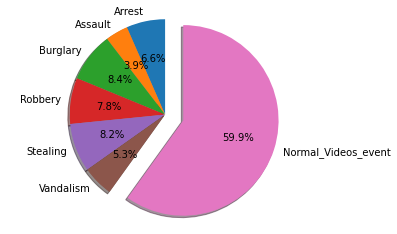

['Arrest', 'Assault', 'Burglary', 'Robbery', 'Stealing', 'Vandalism', 'Normal_Videos_event']
[143, 84, 182, 170, 179, 115, 1305]


In [ ]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Arrest", "Assault", "Burglary", "Robbery", "Stealing", "Vandalism", "Normal_Videos_event"]
sizes = [np.count_nonzero(test_classes[:,0]),np.count_nonzero(test_classes[:,1]),np.count_nonzero(test_classes[:,2]),np.count_nonzero(test_classes[:,3]),np.count_nonzero(test_classes[:,4]),np.count_nonzero(test_classes[:,5]),np.count_nonzero(test_classes[:,6])]
explode = (0, 0, 0, 0, 0, 0, 0.2)  # only "explode" the 2nd slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()
print(labels)
print(sizes)

###Training and Validation

In [ ]:
CNN_classificator, pretrained_base_frame, pretrained_base_opt_flow = build_cnn_model(n_classes = 2, 
                                                                                      input_size = PRETRAINED_INPUT_SIZE, 
                                                                                      pretrained_network = ResNet50,
                                                                                      optical_flow = True,
                                                                                      bag_of_objects = True,
                                                                                      show_summary = False)

####Setup

In [ ]:
from tqdm.notebook import tqdm
import numpy as np   
import gc

class Custom_Data_Generator(keras.utils.Sequence):
  '''
  Custom data generator to be used by keras model utilities to retreive and 
  preprocess batches of data
  '''
  
  def __init__(
      self, 
      indices=None, 
      batch_size=32, 
      shuffle=True,
      path=None,
      binary_classification=False,
      hard_mining=False,
      n_mined=None,
      model=None,
      loss_function=tf.keras.losses.CategoricalCrossentropy(),
      optical_flow_data=None,
      bag_of_objects_data=None,
      frames_data=None,
      classes=None
  ):
      self.batch_size = batch_size
      self.shuffle = shuffle
      self.indices = indices
      self.path = path
      self.binary_classification = binary_classification
      self.hard_mining = hard_mining
      self.n_mined = n_mined
      self.loss_function = loss_function
      self.model = model
      self.on_epoch_end()
      self.optical_flow_data = optical_flow_data
      self.bag_of_objects_data = bag_of_objects_data
      self.frames_data = frames_data
      self.classes = classes

  def on_epoch_end(self):
      # shuffle indicies at epoch start
      self.index = np.arange(len(self.indices))
      if self.shuffle == True:
            np.random.shuffle(self.index)

  def __len__(self):
      # Denotes the number of batches per epoch
      return len(self.indices) // self.batch_size

  def __getitem__(self, index):
      # Generate one batch of data
      # Generate indices of the batch
      index = self.index[index * self.batch_size:(index + 1) * self.batch_size]     # Find list of IDs
      batch = [self.indices[k] for k in index]     # Generate data
      X, y = self.__get_data(batch)
      return X, y

  def getitem(self, index):
    return self.__getitem__(index)

  def __get_data(self, batch):
      # get data from preprocessed videos   

      if self.frames_data is None: 
        # loads batch
        first = True
        for id in tqdm(batch):
          # loads preprocessed data from disk
          preprocess_chunk = np.load(self.path + "preprocessing_" + str(id) + ".npy", allow_pickle=True)
          if first:
            frames_batch = preprocess_chunk[0]
            optical_flows_batch = preprocess_chunk[1]
            boos_bach = preprocess_chunk[2]
            video_classes = preprocess_chunk[3]
            first = False
            if self.binary_classification:
              # transform to binary class
              video_classes = [[c[-1], max(c[0:-1])] for c in video_classes]
          else:
            frames_batch = np.append(frames_batch, preprocess_chunk[0])
            optical_flows_batch = np.append(optical_flows_batch, preprocess_chunk[1])
            boos_bach = np.append(boos_bach, preprocess_chunk[2])
            if self.binary_classification:
              # transform to binary class
              preprocess_chunk[3] = [[c[-1], max(c[0:-1])] for c in preprocess_chunk[3]]
            video_classes = np.append(video_classes, preprocess_chunk[3])

        # correctly reshape inputs and classes
        frames_batch = np.array(frames_batch).reshape(-1,PRETRAINED_INPUT_SIZE[0],PRETRAINED_INPUT_SIZE[1],PRETRAINED_INPUT_SIZE[2])
        optical_flows_batch = np.array(optical_flows_batch).reshape(-1,PRETRAINED_INPUT_SIZE[0],PRETRAINED_INPUT_SIZE[1],PRETRAINED_INPUT_SIZE[2])
        boos_bach = np.array(boos_bach).reshape(-1,N_COCO_CLASSES)
        if self.binary_classification:
          video_classes = np.array(video_classes).reshape(-1,2)
        else:
          video_classes = np.array(video_classes).reshape(-1,N_SUPERVISED_CLASSES)

      else: 
        # Have a dataset loaded
        frames_batch = self.frames_data[batch]
        input_batch = [frames_batch]
        if self.optical_flow_data is not None:
          optical_flows_batch = self.optical_flow_data[batch]
          input_batch.append(optical_flows_batch)
        if self.bag_of_objects_data is not None:  
          boos_bach = self.bag_of_objects_data[batch]
          input_batch.append(boos_bach)
        video_classes = self.classes[batch]
        if self.binary_classification:
          # transform to binary class
          video_classes = [[c[-1], max(c[0:-1])] for c in video_classes]
          video_classes = np.array(video_classes).reshape(-1,2)


      if self.hard_mining:
        # mine only n_mined with higher loss
        predictions = self.model.predict(input_batch, batch_size=self.n_mined)

        # to prevent memory leaking after model.predict
        keras.backend.clear_session() 
        gc.collect()

        mined_indexes = np.array([self.loss_function(video_classes[i],predictions[i]).numpy() for i in range(len(predictions))]).argsort(axis=None)[-self.n_mined:]
        np.random.shuffle(mined_indexes)

        input_batch = [frames_batch[mined_indexes]]
        if self.optical_flow_data is not None:
          input_batch.append(optical_flows_batch[mined_indexes])
        if self.bag_of_objects_data is not None:  
          input_batch.append(boos_bach[mined_indexes])

        return input_batch, video_classes[mined_indexes]

      return input_batch, video_classes

In [ ]:
from jupyterplot import ProgressPlot
import numpy as np

class PlotCallback(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.pp = ProgressPlot(line_names=["Training", "Validation"], x_iterator=False, plot_names=["Accuracy","Loss"], x_label="Epoch")

  def on_train_end(self, logs=None):
    self.pp.finalize()

  def on_epoch_end(self, epoch, logs=None):
    self.pp.update(epoch, [[logs["accuracy"], logs["val_accuracy"]],[logs["loss"], logs["val_loss"]]])

In [ ]:
import datetime
class MailCallback(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.history = "[{}] ---------- TRAINING START ----------".format(datetime.datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    send_email(subject=MAIL_SUBJECT, text=self.history)

  def on_train_end(self, logs=None):
    self.history += "\n[{}] ---------- TRAINING END ----------".format(datetime.datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    send_email(subject=MAIL_SUBJECT, text=self.history)

  def on_epoch_end(self, epoch, logs=None):
    self.history += "\n[{}] EPOCH: {} | TRAIN_ACC: {:7.3f} | TRAIN_LOSS: {:7.3f} | VAL_ACC: {:7.3f} | VAL_LOSS: {:7.3f}".format(datetime.datetime.now().strftime("%Y/%m/%d-%H:%M:%S"), epoch, logs["accuracy"], logs["loss"], logs["val_accuracy"], logs["val_loss"])
    send_email(subject=MAIL_SUBJECT, text=self.history)

####Binary

In [ ]:
MAIL_SUBJECT = "RESNET_BINARY_NO_VALIDATION"
CHECKPOINT_PATH = "Checkpoints/"+MAIL_SUBJECT+"/checkpoint.ckpt"
MAX_EPOCHS = 100
BATCH_SIZE = 16
BINARY_CLASSES = ["Normal", "Anomaly"]

CLASS_WEIGHTS = {0:1., 1:2.}
CANDIDATES_MULTIPLIER = 3

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=False ) 

# Automatically restore best weights after early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

# Tensorboard callback
logdir = os.path.join("Saved/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Generators
training_generator = Custom_Data_Generator(frames_data = train_frames,
                                           optical_flow_data = train_optical_flows, 
                                           bag_of_objects_data = train_boos,
                                           classes = train_classes, 
                                           model=CNN_classificator, 
                                           hard_mining=True, 
                                           n_mined=BATCH_SIZE, 
                                           binary_classification=True, 
                                           indices=range(0,train_classes.shape[0]), 
                                           batch_size=BATCH_SIZE*CANDIDATES_MULTIPLIER, 
                                           shuffle=True, 
                                           path=None)
validation_generator = Custom_Data_Generator(frames_data = val_frames,
                                             optical_flow_data = val_optical_flows, 
                                             bag_of_objects_data = val_boos,
                                             classes = val_classes, 
                                             hard_mining=False, 
                                             binary_classification=True, 
                                             indices=range(0,val_classes.shape[0]), 
                                             batch_size=BATCH_SIZE, 
                                             shuffle=False, 
                                             path=None)

In [ ]:
# Freeze base models
for layer in pretrained_base_frame.layers:
    layer.trainable = False

# Freeze base models
if pretrained_base_opt_flow is not None: 
  for layer in pretrained_base_opt_flow.layers:
      layer.trainable = False

# Check the trainable status of the individual layers
for layer in CNN_classificator.layers:
    print(layer, layer.trainable)

In [ ]:
CNN_classificator.compile(loss='categorical_crossentropy', optimizer= keras.optimizers.Adam(1e-5), metrics=['accuracy'])
 
MAX_EPOCHS = 5

history = CNN_classificator.fit(training_generator, 
                                validation_data = validation_generator, 
                                class_weight=CLASS_WEIGHTS, 
                                epochs=MAX_EPOCHS, 
                                workers=1, 
                                use_multiprocessing=False, 
                                callbacks=[cp_callback, 
                                           #es_callback, 
                                           MailCallback() 
                                           #PlotCallback()
                                           ])
#plot_history(history.history)

In [ ]:
# Check the trainable status of the individual layers
for layer in CNN_classificator.layers:
  # unfreeze all but batch norm layers
  if not "bn" in layer.name:
    layer.trainable = True 
  print(layer, layer.trainable)

In [ ]:
CNN_classificator.compile(loss='categorical_crossentropy', optimizer= keras.optimizers.Adam(1e-6), metrics=['accuracy'])
 
MAX_EPOCHS = 2

history = CNN_classificator.fit(training_generator, 
                                validation_data = validation_generator, 
                                class_weight=CLASS_WEIGHTS, 
                                epochs=MAX_EPOCHS, 
                                workers=1, 
                                use_multiprocessing=False, 
                                callbacks=[cp_callback, 
                                           #es_callback, 
                                           MailCallback() 
                                           #PlotCallback()
                                           ])
#plot_history(history.history)

###Test

####Binary

#####From Drive

In [ ]:
import os
test_videos = [name for name in os.listdir("Saved/CNN_with_normal/Test/") if os.path.isfile(os.path.join("Saved/CNN_with_normal/Test/", name))]

In [ ]:
MODEL = "RESNET_BINARY_NOFLOW_1"
TEST_BATCH_SIZE = 16
CHECKPOINT_PATH = "Checkpoints/{}/checkpoint.ckpt".format(MODEL)

CNN_classificator.load_weights(CHECKPOINT_PATH)

In [ ]:
from threading import Thread
import h5py
import gc

class PredictDataChunk(Thread):        

  def __init__(self, path, model, batch_size):
    self.frames = None
    self.optical_flows = None
    self.boos = None
    self.labels = None
    self.path = path
    self.predicted_classes = None
    self.model = model
    self.batch_size = batch_size
    super(PredictDataChunk, self).__init__()
    print("--- Thread for {} started...".format(self.path))

  def run(self):
    with h5py.File(self.path, "r") as h5f:
      self.frames = h5f["frames_batch"][()]
      self.optical_flows = h5f["optical_flows_batch"][()]
      self.boos = h5f["boos_bach"][()]
      self.labels = h5f["video_classes"][()]
      # correctly reshape inputs and classes
      self.frames = np.array(self.frames).reshape(-1,PRETRAINED_INPUT_SIZE[0],PRETRAINED_INPUT_SIZE[1],PRETRAINED_INPUT_SIZE[2])
      self.optical_flows = np.array(self.optical_flows).reshape(-1,PRETRAINED_INPUT_SIZE[0],PRETRAINED_INPUT_SIZE[1],PRETRAINED_INPUT_SIZE[2])
      self.boos = np.array(self.boos).reshape(-1,N_COCO_CLASSES)
      self.labels = np.array(self.labels).reshape(-1,N_SUPERVISED_CLASSES)

    inputs = [self.frames]
    if any("opt_flow" in i for i in self.model.input_names):
      inputs.append(self.optical_flows)
    if any("bag_of_objects" in i for i in self.model.input_names):
      inputs.append(self.boos) 

    self.predicted_classes = self.model.predict(inputs, self.batch_size)

    # to prevent memory leaking after model.predict
    keras.backend.clear_session() 
    gc.collect()

    print("--- Thread for {} ended...".format(self.path))


In [ ]:
import numpy as np
from time import sleep

folder = "Saved/CNN_with_normal/Test/"
pool_size = 5
videos = len(test_videos)
first = True

for i in range(0, videos, pool_size):

  print("---------- POOL START [{},{}]/{} ----------".format(i,i+pool_size,videos))

  pool = []
  for j in range(i, i + pool_size):
    if j < videos:
      sleep(0.5)
      t = PredictDataChunk(folder+test_videos[j], CNN_classificator, TEST_BATCH_SIZE)
      t.start()
      pool.append(t)
  for t in pool:
    t.join()

  for t in pool:
    if first:
      first = False
      true_lables = t.labels
      predicted_labels = t.predicted_classes
    else:
      true_lables = np.append(true_lables, t.labels)
      predicted_labels = np.append(predicted_labels, t.predicted_classes)

predicted_labels = np.array(predicted_labels).reshape(-1,2)
true_lables = np.array(true_lables).reshape(-1,N_SUPERVISED_CLASSES)
true_lables = np.array([[c[-1], max(c[0:-1])] for c in true_lables])

#####In Memory

In [ ]:
MODEL = MAIL_SUBJECT
TEST_BATCH_SIZE = 16
CHECKPOINT_PATH = "Checkpoints/{}/checkpoint.ckpt".format(MODEL)
N_TEST_FRAMES = test_classes.shape[0]

CNN_classificator.load_weights(CHECKPOINT_PATH)
test_generator = Custom_Data_Generator( frames_data = test_frames,
                                        optical_flow_data = test_optical_flows,
                                        bag_of_objects_data = test_boos,
                                        classes = test_classes, 
                                        hard_mining=False, 
                                        binary_classification=True, 
                                        indices=range(0,test_classes.shape[0]), 
                                        batch_size=TEST_BATCH_SIZE, 
                                        shuffle=False, 
                                        path=None)

In [ ]:
from tqdm.notebook import tqdm

first = True
for i in tqdm(range(0,N_TEST_FRAMES//TEST_BATCH_SIZE)):
  X,y = test_generator.getitem(i)
  predicted_classes = CNN_classificator.predict(X)
  if first:
    first = False
    true_lables = y
    predicted_labels = predicted_classes
  else:
    true_lables = np.append(true_lables, y)
    predicted_labels = np.append(predicted_labels, predicted_classes)

predicted_labels = np.array(predicted_labels).reshape(-1,2)
true_lables = np.array(true_lables).reshape(-1,2)

#####Results

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

true_y = [y.argmax() for y in true_lables]
pred_y = [y.argmax() for y in predicted_labels]

cf_matrix = confusion_matrix(true_y, pred_y)
make_confusion_matrix(cf_matrix, categories=BINARY_CLASSES)

In [ ]:
fpr, tpr, _ = roc_curve(true_lables[:,0], predicted_labels[:,0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=plt.cm.winter(1),lw=2, label= "CNN binary" + ' (area = %0.3f)' % roc_auc)
    
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

##C3D

###Preprocessing

In [ ]:
import cv2
import numpy as np
from IPython.display import clear_output 
from time import sleep
from collections import Counter
from sklearn.preprocessing import Normalizer
from tqdm.notebook import tqdm
import math
import os
import h5py
import _thread

def video_preprocessing_c3d(
                videos_split = train_split,
                input_size = C3D_INPUT_SIZE,
                sample_rate = 4, # equivalent to 2.13 seconds chunks (2 seconds in original paper)
                not_consider_normal_in_anomalies = True,
                store_one_video_at_time=False,
                temporal_stride = 4, # (8 in original paper)
                normal_videos_temporal_stride = 8, # to undersampling normal videos preserving variety
                save_path = "Saved/C3D_preprocessed_data/Training/",
                object_detector = yolo
              ):

  for video, video_idx in zip(videos_split[0],range(0,len(videos_split))):

    retry = True
    while retry:
    # Retry till success
      retry = False

      try:
        # Variables 
        first_frame = True
        accumulated_frames = None
        accumulated_boo = None
        new_acc_frames_count = 0
        first_accumulation = True
        save = False
        chunk_count = 0
        anomalous_video = "Normal_Videos" not in video # True if anomalous
        normal_video = "Normal_Videos" in video # True if normal

        if anomalous_video:
          annotations = pd.read_csv("Data/framebyframe_annotations/annotations/"+video+".txt", header=None,sep=" ")
          video_class = annotations.iloc[:,-1][0]
          frame_annotations = annotations[annotations[6] != 1][5].tolist()
        else:
          video_class = "Normal_Videos_event"

        # Capture video from file or link
        if anomalous_video:
          video_path = "Data/Videos/" + video_class + "/" + video.strip() + "_x264.mp4"
        else:
          video_path = "Data/Videos/Training_Normal_Videos_Anomaly/" + video.strip() + "_x264.mp4"

        print("Video: " + str(video_path))

        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Loop the video
        for frame_idx in tqdm(range(0, total_frames)):

          # Read frames in order
          _, frame = cap.read()

          if frame_idx % sample_rate == 0:
            # Frame to be elaborated

            if not normal_video:
              anomalous_frame = frame_idx in frame_annotations # true if anomalous

            if anomalous_video and anomalous_frame:
              # anomalous frame
              frame_class = video_class
            else:
              # normal frame in anomalous video
              frame_class = "Normal_Videos_event"

            # class in one_hot_encoding
            one_hot_class = np.zeros(N_SUPERVISED_CLASSES)
            one_hot_class[CLASSES.index(frame_class)] = 1

            # objects detection
            if not not_consider_normal_in_anomalies or (not_consider_normal_in_anomalies and anomalous_video and anomalous_frame) or normal_video:
              # only normal frames in normal videos or anomalous frames in anomalous videos if not_consider_normal_in_anomalies == True
                
              # # objects detection
              frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
              _, bag_of_objects = yolov4_detect_bag_of_objects(frame_rgb, object_detector)

              # features extraction
              # preprocess_input want RGB images in input
              frame_resized = cv2.resize(frame_rgb, (input_size[1],input_size[2]), interpolation = cv2.INTER_AREA)
            
              if first_frame:

                # first accumulated frame
                first_frame = False
                accumulated_frames = np.array(frame_resized)
                accumulated_boos = np.array(bag_of_objects)
                new_acc_frames_count = 1
                first_accumulation = True
                #print(f"First {(frame_idx // sample_rate)}")

              else: 

                if first_accumulation:
                  # Need to accumulate all frames from first one
                  accumulated_frames = np.append(accumulated_frames,frame_resized)
                  accumulated_boos = np.append(accumulated_boos, bag_of_objects)
                  new_acc_frames_count += 1
                  if new_acc_frames_count == input_size[0]:
                    # All frames accumulated, save
                    first_accumulation = False
                    new_acc_frames_count = 0
                    accumulated_frames = accumulated_frames.reshape(input_size[0],input_size[1],input_size[2],input_size[3])
                    accumulated_boos = accumulated_boos.reshape(-1,N_COCO_CLASSES)
                    save = True
                    #print(f"Save first {(frame_idx // sample_rate) + 1}")

                else:
                  # need other "temporal_stride" frames 
                  accumulated_frames = accumulated_frames[1:] # pop first
                  accumulated_frames = np.append(accumulated_frames,frame_resized)
                  accumulated_frames = accumulated_frames.reshape(input_size[0],input_size[1],input_size[2],input_size[3])
                  accumulated_boos = accumulated_boos[1:]
                  accumulated_boos = np.append(accumulated_boos,bag_of_objects)
                  accumulated_boos = accumulated_boos.reshape(-1,N_COCO_CLASSES)
                  new_acc_frames_count += 1
                  if (anomalous_video and new_acc_frames_count == temporal_stride) or (normal_video and new_acc_frames_count == normal_videos_temporal_stride):
                    # New "temporal_stride" frames accumulated, save
                    new_acc_frames_count = 0
                    save = True
                    #print(f"Save next {(frame_idx // sample_rate) + 1}")

                if save:
                  # save frames chunk
                  save = False

                  tmp_path = f"{save_path}{str(video.strip())}/"

                  if not os.path.exists(tmp_path):
                    os.makedirs(tmp_path)

                  # too large for classical numpy save
                  with h5py.File(f"{tmp_path}preprocessing_{chunk_count}", 'w') as hf:
                    hf.create_dataset("accumulated_frames",  data=accumulated_frames)
                    hf.create_dataset("one_hot_class", data=one_hot_class)
                    hf.create_dataset("accumulated_boos", data=accumulated_boos)

                  chunk_count += 1

            else:
              # Normal frame in anomalous video
              first_frame = True #restart accumulation

      except Exception as ex:
        # To prevent redoing all preprocessing for some I/O error
        print("ERROR: '" + str(ex) + "' for " + str(video.strip()) + " retrying...")
        retry = True

In [ ]:
from threading import Thread

pool_size = 12
videos = len(train_split)

# Preprocess all videos 
for i in range(0, videos, pool_size):

  print("---------- POOL START [{},{}]/{} ----------".format(i,i+pool_size,videos))

  pool = []
  for j in range(i, i + pool_size):
    if j < videos:
      t = Thread( target=video_preprocessing_c3d, args=(train_split[j:j+1],C3D_INPUT_SIZE,4,True,False,4,8,"Saved/C3D_preprocessed_data/Training/") )
      t.start()
      pool.append(t)
  for t in pool:
    t.join()

In [ ]:
from threading import Thread

pool_size = 12
videos = len(val_split)

# Preprocess all videos 
for i in range(0, videos, pool_size):

  print("---------- POOL START [{},{}]/{} ----------".format(i,i+pool_size,videos))

  pool = []
  for j in range(i, i + pool_size):
    if j < videos:
      t = Thread( target=video_preprocessing_c3d, args=(val_split[j:j+1],C3D_INPUT_SIZE,4,True,False,4,8,"Saved/C3D_preprocessed_data/Validation/") )
      t.start()
      pool.append(t)
  for t in pool:
    t.join()

In [ ]:
from threading import Thread

pool_size = 12
videos = len(test_split)

# Preprocess all videos 
for i in range(0, videos, pool_size):

  print("---------- POOL START [{},{}]/{} ----------".format(i,i+pool_size,videos))

  pool = []
  for j in range(i, i + pool_size):
    if j < videos:
      t = Thread( target=video_preprocessing_c3d, args=(test_split[j:j+1],C3D_INPUT_SIZE,4,True,False,4,8,"Saved/C3D_preprocessed_data/Test/") )
      t.start()
      pool.append(t)
  for t in pool:
    t.join()

###Data Loading

In [ ]:
from threading import Thread
import h5py

class GetDataChunk(Thread):        

  def __init__(self, path):
    self.frames = None
    self.classes = None
    self.bag_of_objects = None
    self.path = path
    super(GetDataChunk, self).__init__()
    print("--- Thread for {} started...".format(self.path))

  def run(self):
    with h5py.File(self.path, "r") as h5f:
      self.frames = h5f["accumulated_frames"][()]
      self.classes = h5f["one_hot_class"][()]
      self.bag_of_objects = h5f["accumulated_boos"][()]
      print("--- Thread for {} ended...".format(self.path))

In [ ]:
import os
train_videos = []
val_videos = []
test_videos = []

# Get file-names in folders
for path, subdirs, files in os.walk("Saved/C3D_preprocessed_data/Training/"):
    for name in files:
        train_videos.append(os.path.join(path, name))

# Get file-names in folders
for path, subdirs, files in os.walk("Saved/C3D_preprocessed_data/Validation/"):
    for name in files:
        val_videos.append(os.path.join(path, name))

# Get file-names in folders
for path, subdirs, files in os.walk("Saved/C3D_preprocessed_data/Test/"):
    for name in files:
        test_videos.append(os.path.join(path, name))

In [ ]:
import numpy as np
from time import sleep
from tqdm.notebook import tqdm

pool_size = 12
videos = len(train_videos)
first = True

for i in tqdm(range(0, videos, pool_size)):

  print("---------- POOL START [{},{}]/{} ----------".format(i,i+pool_size,videos))

  pool = []
  for j in range(i, i + pool_size):
    if j < videos:
      sleep(0.1)
      t = t = GetDataChunk(train_videos[j])
      t.start()
      pool.append(t)
  for t in pool:
    t.join()

  for t in pool:
    if first:
      train_frames = t.frames
      train_classes = t.classes
      train_bag_of_objects = t.bag_of_objects
      first = False
    else:
      train_frames = np.append(train_frames,t.frames)
      train_classes = np.append(train_classes,t.classes)
      train_bag_of_objects = np.append(train_bag_of_objects,t.bag_of_objects)

# correctly reshape inputs and classes
train_frames = np.array(train_frames).reshape(-1,C3D_INPUT_SIZE[0],C3D_INPUT_SIZE[1],C3D_INPUT_SIZE[2],C3D_INPUT_SIZE[3])
train_classes = np.array(train_classes).reshape(-1,N_SUPERVISED_CLASSES)
train_bag_of_objects = np.array(train_bag_of_objects).reshape(-1,C3D_INPUT_SIZE[0],N_COCO_CLASSES)

print(train_frames.shape)
print(train_classes.shape)
print(train_bag_of_objects.shape)

In [ ]:
import numpy as np
from time import sleep
from tqdm.notebook import tqdm

pool_size = 12
videos = len(val_videos)
first = True

for i in tqdm(range(0, videos, pool_size)):

  print("---------- POOL START [{},{}]/{} ----------".format(i,i+pool_size,videos))

  pool = []
  for j in range(i, i + pool_size):
    if j < videos:
      sleep(0.1)
      t = t = GetDataChunk(val_videos[j])
      t.start()
      pool.append(t)
  for t in pool:
    t.join()

  for t in pool:
    if first:
      val_frames = t.frames
      val_classes = t.classes
      val_bag_of_objects = t.bag_of_objects
      first = False
    else:
      val_frames = np.append(val_frames,t.frames)
      val_classes = np.append(val_classes,t.classes)
      val_bag_of_objects = np.append(val_bag_of_objects,t.bag_of_objects)

# correctly reshape inputs and classes
val_frames = np.array(val_frames).reshape(-1,C3D_INPUT_SIZE[0],C3D_INPUT_SIZE[1],C3D_INPUT_SIZE[2],C3D_INPUT_SIZE[3])
val_classes = np.array(val_classes).reshape(-1,N_SUPERVISED_CLASSES)
val_bag_of_objects = np.array(val_bag_of_objects).reshape(-1,C3D_INPUT_SIZE[0],N_COCO_CLASSES)

print(val_frames.shape)
print(val_classes.shape)
print(val_bag_of_objects.shape)

In [ ]:
import numpy as np
from time import sleep
from tqdm.notebook import tqdm

pool_size = 12
videos = len(test_videos)
first = True

for i in tqdm(range(0, videos, pool_size)):

  print("---------- POOL START [{},{}]/{} ----------".format(i,i+pool_size,videos))

  pool = []
  for j in range(i, i + pool_size):
    if j < videos:
      sleep(0.1)
      t = t = GetDataChunk(test_videos[j])
      t.start()
      pool.append(t)
  for t in pool:
    t.join()

  for t in pool:
    if first:
      test_frames = t.frames
      test_classes = t.classes
      test_bag_of_objects = t.bag_of_objects
      first = False
    else:
      test_frames = np.append(test_frames,t.frames)
      test_classes = np.append(test_classes,t.classes)
      test_bag_of_objects = np.append(test_bag_of_objects,t.bag_of_objects)

# correctly reshape inputs and classes
test_frames = np.array(test_frames).reshape(-1,C3D_INPUT_SIZE[0],C3D_INPUT_SIZE[1],C3D_INPUT_SIZE[2],C3D_INPUT_SIZE[3])
test_classes = np.array(test_classes).reshape(-1,N_SUPERVISED_CLASSES)
test_bag_of_objects = np.array(test_bag_of_objects).reshape(-1,C3D_INPUT_SIZE[0],N_COCO_CLASSES)

print(test_frames.shape)
print(test_classes.shape)
print(test_bag_of_objects.shape)

###Save All

In [ ]:
with h5py.File("Saved/C3D_preprocessed_data/all_preprocessing", 'w') as hf:
  hf.create_dataset("train_frames",  data=train_frames)
  hf.create_dataset("train_classes", data=train_classes)
  hf.create_dataset("train_bag_of_objects", data=train_bag_of_objects)
  hf.create_dataset("val_frames",  data=val_frames)
  hf.create_dataset("val_classes", data=val_classes)
  hf.create_dataset("val_bag_of_objects", data=val_bag_of_objects)
  hf.create_dataset("test_frames",  data=test_frames)
  hf.create_dataset("test_classes", data=test_classes)
  hf.create_dataset("test_bag_of_objects", data=test_bag_of_objects)

###Quick Load

In [ ]:
import h5py
with h5py.File("Saved/C3D_preprocessed_data/all_preprocessing", "r") as h5f:
  train_frames = h5f["train_frames"][()]
  train_classes = h5f["train_classes"][()]
  train_bag_of_objects = h5f["train_bag_of_objects"][()]
  val_frames = h5f["val_frames"][()]
  val_classes = h5f["val_classes"][()]
  val_bag_of_objects = h5f["val_bag_of_objects"][()]
  test_frames = h5f["test_frames"][()]
  test_classes = h5f["test_classes"][()]
  test_bag_of_objects = h5f["test_bag_of_objects"][()]

In [ ]:
print(train_frames.shape)
print(train_classes.shape)
print(train_bag_of_objects.shape)
print(val_frames.shape)
print(val_classes.shape)
print(val_bag_of_objects.shape)
print(test_frames.shape)
print(test_classes.shape)
print(test_bag_of_objects.shape)

###Training and Validation

In [ ]:
c3d_classificator, c3d_base_model = build_c3d_model(
                                  n_classes=2,
                                  input_shape=(16, 112, 112, 3),
                                  c3d_weight_path='C3D/C3D_Sport1M_weights.h5',
                                  dim_bag_of_objects=None,
                                  show_summary=True
                                )

####Setup

In [ ]:
from tqdm.notebook import tqdm
import numpy as np   
import gc

class Custom_Data_Generator(keras.utils.Sequence):
  '''
  Custom data generator to be used by keras model utilities to retreive and 
  preprocess batches of data
  '''
  
  def __init__(
      self, 
      indices=None, 
      batch_size=32, 
      shuffle=True,
      path=None,
      binary_classification=False,
      hard_mining=False,
      n_mined=None,
      model=None,
      loss_function=tf.keras.losses.CategoricalCrossentropy(),
      data=None #last column need to be the class
  ):
      self.batch_size = batch_size
      self.shuffle = shuffle
      self.indices = indices
      self.path = path
      self.binary_classification = binary_classification
      self.hard_mining = hard_mining
      self.n_mined = n_mined
      self.loss_function = loss_function
      self.model = model
      self.on_epoch_end()
      self.data = data

  def on_epoch_end(self):
      # shuffle indicies at epoch start
      self.index = np.arange(len(self.indices))
      if self.shuffle == True:
            np.random.shuffle(self.index)

  def __len__(self):
      # Denotes the number of batches per epoch
      return len(self.indices) // self.batch_size

  def __getitem__(self, index):
      # Generate one batch of data
      # Generate indices of the batch
      index = self.index[index * self.batch_size:(index + 1) * self.batch_size]     # Find list of IDs
      batch = [self.indices[k] for k in index]     # Generate data
      X, y = self.__get_data(batch)
      return X, y

  def getitem(self, index):
    return self.__getitem__(index)

  def __get_data(self, batch):
      # get data from preprocessed videos   
      # Have a dataset loaded
      video_classes = self.data[-1][batch]
      inputs = []
      for column in self.data[:-1]:
        inputs.append(column[batch])

      if self.binary_classification:
        # transform to binary class
        video_classes = [[c[-1], max(c[0:-1])] for c in video_classes]
        video_classes = np.array(video_classes).reshape(-1,2)

      if self.hard_mining:
        # mine only n_mined with higher loss
        predictions = self.model.predict(inputs, self.n_mined)

        # to prevent memory leaking after model.predict
        keras.backend.clear_session() 
        gc.collect()

        # select indexes with higher loss
        mined_indexes = np.array([self.loss_function(video_classes[i],predictions[i]).numpy() for i in range(len(predictions))]).argsort(axis=None)[-self.n_mined:]
        np.random.shuffle(mined_indexes)

        mined_inputs = []
        for column in inputs:
          mined_inputs.append(column[mined_indexes])

        return mined_inputs, video_classes[mined_indexes]

      return inputs, video_classes

In [ ]:
from jupyterplot import ProgressPlot
import numpy as np

class PlotCallback(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.pp = ProgressPlot(line_names=["Training", "Validation"], x_iterator=False, plot_names=["Accuracy","Loss"], x_label="Epoch")

  def on_train_end(self, logs=None):
    self.pp.finalize()

  def on_epoch_end(self, epoch, logs=None):
    self.pp.update(epoch, [[logs["accuracy"], logs["val_accuracy"]],[logs["loss"], logs["val_loss"]]])

In [ ]:
import datetime
class MailCallback(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.history = "[{}] ---------- TRAINING START ----------".format(datetime.datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    send_email(subject=MAIL_SUBJECT, text=self.history)

  def on_train_end(self, logs=None):
    self.history += "\n[{}] ---------- TRAINING END ----------".format(datetime.datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    send_email(subject=MAIL_SUBJECT, text=self.history)

  def on_epoch_end(self, epoch, logs=None):
    self.history += "\n[{}] EPOCH: {} | TRAIN_ACC: {:7.3f} | TRAIN_LOSS: {:7.3f} | VAL_ACC: {:7.3f} | VAL_LOSS: {:7.3f}".format(datetime.datetime.now().strftime("%Y/%m/%d-%H:%M:%S"), epoch, logs["accuracy"], logs["loss"], logs["val_accuracy"], logs["val_loss"])
    send_email(subject=MAIL_SUBJECT, text=self.history)

####Binary

In [ ]:
MAIL_SUBJECT = "C3D_BINARY_NOBOO_NO_VAL_2"
CHECKPOINT_PATH = "Checkpoints/"+MAIL_SUBJECT+"/checkpoint.ckpt"
MAX_EPOCHS = 100
BATCH_SIZE = 16
BINARY_CLASSES = ["Normal", "Anomaly"]

CLASS_WEIGHTS = {0:1., 1:2.}
CANDIDATES_MULTIPLIER = 3

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH,  
    verbose=1, 
    save_weights_only=True,
    save_best_only=False ) 

# Automatically restore best weights after early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

# Generators
training_generator = Custom_Data_Generator(
                                           data=[train_frames,train_classes], 
                                           model=c3d_classificator, 
                                           hard_mining=True, 
                                           n_mined=BATCH_SIZE, # actual batch size mined from candidates
                                           binary_classification=True, 
                                           indices=range(0,train_classes.shape[0]), 
                                           batch_size=BATCH_SIZE*CANDIDATES_MULTIPLIER, # n. candidates 
                                           shuffle=True
                                          )

# Binary val classes
val_classes_binary = np.array([[c[-1], max(c[0:-1])] for c in val_classes])
train_classes_binary = np.array([[c[-1], max(c[0:-1])] for c in train_classes])

Train only top layers:

In [ ]:
# Freeze Top C3D layers
for layer in c3d_base_model.layers[:-6]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in c3d_classificator.layers:
    print(layer, layer.trainable)

In [ ]:
# Train ONLY custom layers
LEARNING_RATE = 1e-5
c3d_classificator.compile(
                  loss='categorical_crossentropy', 
                  optimizer= keras.optimizers.Adam(LEARNING_RATE),
                  metrics=['accuracy']
                  )

MAX_EPOCHS = 4

tf.config.run_functions_eagerly(True) 
history = c3d_classificator.fit(
                        training_generator, #hard mining
                        validation_data = ([val_frames],val_classes_binary), 
                        validation_batch_size=BATCH_SIZE, 
                        class_weight=CLASS_WEIGHTS, 
                        epochs=MAX_EPOCHS, 
                        workers=1, 
                        use_multiprocessing=False, 
                        callbacks=[#es_callback, 
                                   cp_callback, 
                                   MailCallback(), 
                                   PlotCallback()]
                      )

plot_history(history.history)

Fine tuning on ALL layers:

In [ ]:
# Fine tuning on ALL layers
c3d_base_model.trainable = True

In [ ]:
LEARNING_RATE = 1e-6 # very slow learning rate
c3d_classificator.compile(
                  loss='categorical_crossentropy', 
                  optimizer= keras.optimizers.Adam(LEARNING_RATE), 
                  metrics=['accuracy']
                  )
MAX_EPOCHS = 1
tf.config.run_functions_eagerly(True) 
history = c3d_classificator.fit(
                        training_generator, # Hard mining
                        validation_data = (val_frames,val_classes_binary), 
                        validation_batch_size=BATCH_SIZE, 
                        class_weight=CLASS_WEIGHTS, 
                        epochs=MAX_EPOCHS, 
                        workers=1, 
                        use_multiprocessing=False, 
                        callbacks=[#es_callback, 
                                   cp_callback, 
                                   MailCallback(), 
                                   PlotCallback()]
                      )

plot_history(history.history)

###Test

####Binary

In [ ]:
MODEL = "C3D_BINARY_NOBOO_1"
TEST_BATCH_SIZE = 16
CHECKPOINT_PATH = "Checkpoints/{}/checkpoint.ckpt".format(MODEL)
N_TEST_FRAMES = test_classes.shape[0]

c3d_classificator.load_weights(CHECKPOINT_PATH)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

predicted_labels = c3d_classificator.predict([test_frames], TEST_BATCH_SIZE)
true_lables = np.array([[c[-1], max(c[0:-1])] for c in test_classes])

true_y = [y.argmax() for y in true_lables]
pred_y = [y.argmax() for y in predicted_labels]

cf_matrix = confusion_matrix(true_y, pred_y)
make_confusion_matrix(cf_matrix, categories=BINARY_CLASSES)

In [ ]:
fpr, tpr, _ = roc_curve(true_lables[:,0], predicted_labels[:,0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=plt.cm.winter(1),lw=2, label= "CNN binary" + ' (area = %0.3f)' % roc_auc)
    
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

# Visual Testing

##GradCam

In [ ]:
import numpy as np

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
def get_img_array(img_path, size, preprocess_function = None):
    # `img` is a PIL image of size nxnx3
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (n, n, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # preprocess if needed
    if preprocess_function is not None:
      preprocess_function(array)
    # We add a dimension to transform our array into a "batch"
    # of size (1, n, n, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(model_inputs, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(model_inputs)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = (tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap))
    return heatmap.numpy()

In [ ]:
def calc_gradcam(heatmap, img_path=None, img=None, alpha=0.4, show=False, colour_map="jet", reverse_cmap = False):

    if img_path is not None:
      # Load the original image
      img = keras.preprocessing.image.load_img(img_path)
      img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap(colour_map)

    if reverse_cmap:
      jet = jet.reversed()

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img

    if show:
      # Display Grad CAM
      display(keras.preprocessing.image.array_to_img(superimposed_img))

    return superimposed_img

## Real Time DEMO

###Setup

In [ ]:
import pandas as pd

train_split = pd.read_csv("Data/framebyframe_annotations/Train_split_AD.txt", header=None)
test_val_split = pd.read_csv("Data/framebyframe_annotations/Test_split_AD.txt", header=None)
# reservations odd rows, even rows deleted
test_split=test_val_split[test_val_split.index%2==0]
# retained even rows, delete odd lines
val_split=test_val_split[test_val_split.index%2==1]

In [ ]:
import math

class AnomalyScore:
  def __init__(self, sensibility_threshold=0.5, reactivity = 2, acc_value=-7, max=7, min=-7):
    self.acc_value = acc_value
    self.max = max
    self.min = min
    self.threshold = sensibility_threshold
    self.score = 0
    self.reactivity = reactivity

  def add(self, anom_prob):
    if anom_prob >= self.threshold:
      self.acc_value = self.acc_value + ((anom_prob-self.threshold)/(1 - self.threshold))*self.reactivity if self.acc_value < self.max else self.max
    else:
      normal_prob = 1 - anom_prob
      normal_trashold = 1 - self.threshold
      self.acc_value = self.acc_value - ((normal_prob-normal_trashold)/(1 - normal_trashold))*self.reactivity if self.acc_value > self.min else self.min
      
    self.score = (1/(1+math.exp(-self.acc_value)))*100 # sig -> (0,100)

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow as imshow
from IPython.display import clear_output 
from time import sleep
from collections import Counter
from sklearn.preprocessing import Normalizer
from jupyterplot import ProgressPlot

def visual_test(
                classificator_model,
                videos_split,
                last_conv_layer = None,
                optical_flow = True,
                object_detector = None,
                feature_extractor = None,
                binary = True,
                sample_rate = 10,
                plot = True,
                visual_test = False,
                show_gradCam = False,
                frame_size = None,
                sensibility_threshold=0.5, 
                reactivity = 2,
                labeled = True,
                clear_previous = True
):

  anomaly_list = []
  anomalous_videos = []
  normal_videos = []
  first_prediction = True

  c3d = False
  cnn = True
  if len(frame_size) == 4:
    # Need a block, not a single frame
    c3d = True
    cnn = False
    block_size = frame_size
    frame_size = frame_size[1:]

  for video, video_idx in zip(videos_split ,range(0,len(videos_split))):

    anomaly_detected = False

    if c3d:
      # Initialized with zeros
      frames_block = np.zeros(block_size, dtype=np.float)
      if not object_detector == None:
        bag_of_objects_block = np.zeros((block_size[0],N_COCO_CLASSES), dtype=np.float)

    # Initialize new anomaly score
    anomaly_score = AnomalyScore(sensibility_threshold=sensibility_threshold, reactivity = reactivity)

    if labeled:
      # for labelled videos
      if "Normal_Videos" not in video:
        annotations = pd.read_csv("Data/framebyframe_annotations/annotations/"+video+".txt", header=None,sep=" ")
        video_class = annotations.iloc[:,-1][0]
        frame_annotations = annotations[annotations[6] != 1][5].tolist()
      else:
        video_class = "Normal_Videos_event"

      # Capture video from file or link
      if "Normal_Videos" not in video:
        video_path = "Data/Videos/" + video_class + "/" + video.strip() + "_x264.mp4"
      else:
        video_path = "Data/Videos/Training_Normal_Videos_Anomaly/" + video.strip() + "_x264.mp4"
    else:
      # for other videos pass directly the path
      video_path = video

    # Capture video from file or link
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # read first frame
    ret, frame1 = cap.read() # BGR
    prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255

    flow = None

    if plot:
      if clear_previous:
        clear_output(wait=True) 
      print(f"Anomalies Found: {sum(anomaly_list)}/{len(anomaly_list)}")
      print(f"Index: {video_idx+1}/{len(videos_split)}")

    print("VIDEO {} -----------------------".format(video))
    if plot:
      pp = ProgressPlot(line_names=["SAS", "True", "Predicted"], x_iterator=False, plot_names=[video], x_label="Second", y_lim=[0,100])
      frame_list = []
      SAS_list = []
      true_list = []
      predicted_list = []

    # Loop the video
    for frame_idx in range(1, total_frames):

      ret, frame2 = cap.read()

      if frame_idx % sample_rate == 0:

        # read next frame
        next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

        if optical_flow:
          # calculate optical flow using previous and next frames (using default params)
          # 6th parameter: larger values increase the algorithm robustness to image noise and give more chances for fast motion detection, but yield more blurred motion field
          flow = cv2.calcOpticalFlowFarneback(prvs, next, flow, 0.5, 3, 15, 3, 5, 1.2, 0)

          # convert flow to rgb 
          mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
          hsv[...,0] = ang*180/np.pi/2
          hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
          rgb_optical_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

          prvs = next

        frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

        if not object_detector == None:
          # objects detection
          detections, bag_of_objects = yolov4_detect_bag_of_objects(frame2_rgb, yolo)

        # features extraction
        # preprocess_input want RGB images in input
        frame2_resized = cv2.resize(frame2_rgb, (frame_size[0],frame_size[1]), interpolation = cv2.INTER_AREA)

        if optical_flow:
          optical_flow_resized = cv2.resize(rgb_optical_flow, (frame_size[0],frame_size[1]), interpolation = cv2.INTER_AREA)

        classificator_input = []

        if cnn:
          classificator_input.append(resnet.preprocess_input(frame2_resized).reshape(1,frame_size[0],frame_size[1],frame_size[2]))
          if optical_flow:
            classificator_input.append(resnet.preprocess_input(optical_flow_resized).reshape(1,frame_size[0],frame_size[1],frame_size[2]))
          if not object_detector == None:
            classificator_input.append(bag_of_objects.reshape(1,N_COCO_CLASSES))

        if c3d:
          frames_block = frames_block[1:] # pop first
          frames_block = np.append(frames_block,frame2_resized)
          frames_block = frames_block.reshape(block_size[0],block_size[1],block_size[2],block_size[3])
          classificator_input.append(frames_block.reshape(1,block_size[0],block_size[1],block_size[2],block_size[3])) #add batch dimention
          if not object_detector == None:
            bag_of_objects_block = bag_of_objects_block[1:] # pop first
            bag_of_objects_block = np.append(bag_of_objects_block,bag_of_objects)
            bag_of_objects_block = bag_of_objects_block.reshape(block_size[0],N_COCO_CLASSES)
            classificator_input.append(bag_of_objects_block.reshape(1,block_size[0],N_COCO_CLASSES)) #add batch dimention

        if not feature_extractor == None:
          # cnn predictions for lstm classificator
          classificator_input = feature_extractor.predict(classificator_input)
          classificator_input = classificator_input.reshape(1,1,-1)

        # predictions
        prediction = classificator_model.predict(classificator_input)

        if labeled and "Normal_Videos" not in video and frame_idx in frame_annotations:
          frame_class = video_class
        else:
          frame_class = "Normal_Videos_event"

        # class in one_hot_encoding
        one_hot_class = np.zeros(N_SUPERVISED_CLASSES)
        one_hot_class[CLASSES.index(frame_class)] = 1

        if binary:
          # Transform to normal-anomaly binary classes
          one_hot_class = np.array([one_hot_class[-1], max(one_hot_class[0:-1])])

        if first_prediction:
          predicted_classes = np.array(prediction)
          true_classes = one_hot_class
          first_prediction = False
        else:
          predicted_classes = np.append(predicted_classes, prediction)
          true_classes = np.append(true_classes, one_hot_class)

        if plot:
          anomaly_score.add(prediction[0][1])
          if anomaly_score.score > 50:
            anomaly_detected = True
          # 30 FPS
          pp.update(frame_idx / 30, [[anomaly_score.score, 0 if "Normal_Videos_event" in frame_class else 100, prediction[0][1]*100]])

          frame_list.append(frame_idx)
          SAS_list.append(anomaly_score.score * 0.01)
          true_list.append(0 if "Normal_Videos_event" in frame_class else 1)
          predicted_list.append(prediction[0][1])


        if visual_test:
          # for visual testing 
          clear_output(wait=True)

          print("VIDEO {} -----------------------".format(video))
          print("FRAME {}/{}".format(frame_idx,total_frames))
          print()
          print("CLASS: {}".format(frame_class))
          print()
          
          if binary:
            print("NORMAL_PROB: {:3.0f}%".format(prediction[0][0]*100))
            print("ANOMALY_PROB: {:3.0f}%".format(prediction[0][1]*100))
            print("ANOMALY_SCORE: {:3.0f}%".format(anomaly_score.score))

          if not object_detector == None:

            # create transparent overlay for bounding box
            bbox_array = np.zeros([480,640,4], dtype=np.uint8)

            # loop over the detected objects
            for obj, i in zip(detections, range(len(detections))):
            
              #(x, y, w, h, cls_id, prob)

              # extract the bounding box coordinates
              (x, y) = (int(obj[0]*frame2.shape[1]), int(obj[1]*frame2.shape[0]))
              (w, h) = (int(obj[2]*frame2.shape[1]), int(obj[3]*frame2.shape[0]))

              # convert to corners
              x_start = round(x-w/2)
              y_start = round(y-h/2)
              x_end = round(x_start + w)
              y_end = round(y_start + h)

              # Bounding box color 
              color = (0,0,255) #BGR red

              # draw a bounding box rectangle and label on the frame
              cv2.rectangle(frame2, (x_start,y_start), (x_end, y_end), color, 2)
              text = "{}: {:0.2f}".format(COCO_CLASSES[int(obj[4])], obj[5])
              cv2.putText(frame2,text,(x_start,y_start-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,color)
          
          if show_gradCam:
            # GradCam
            frame_gradCam = frame2
            frame_heatmap = make_gradcam_heatmap(classificator_input, classificator_model, last_conv_layer + "_frame")
            frame_gradCam = calc_gradcam(frame_heatmap, img = frame2_rgb, alpha=1)
            frame_gradCam = cv2.cvtColor(frame_gradCam, cv2.COLOR_RGB2BGR)
            juxtaposition = (frame2, frame_gradCam)
            j_size = 800
            if optical_flow:
              opt_flow = cv2.cvtColor(rgb_optical_flow, cv2.COLOR_RGB2BGR)
              opt_flow_gradCam = opt_flow
              opt_flow_heatmap = make_gradcam_heatmap(classificator_input, classificator_model, last_conv_layer + "_opt_flow")
              opt_flow_gradCam = calc_gradcam(opt_flow_heatmap, img = rgb_optical_flow, alpha=1)
              opt_flow_gradCam = cv2.cvtColor(opt_flow_gradCam, cv2.COLOR_RGB2BGR)
              juxtaposition = (opt_flow, opt_flow_gradCam, frame2, frame_gradCam)
              j_size = 1600

          # juxtapose flow with frame 
          horizontal_juxtapose  = np.hstack(juxtaposition)

          # clear previous and show next images
          imshow(cv2.resize(horizontal_juxtapose,(j_size,400)))

          sleep(sample_rate/30)
          input("")

    if plot:
      pp.finalize()
    anomaly_list.append(anomaly_detected)
    if anomaly_detected:
      anomalous_videos.append(video)
    else:
      normal_videos.append(video)
  
  if binary:
    true_classes = np.array(true_classes).reshape(-1,2)
    predicted_classes = np.array(predicted_classes).reshape(-1,2)
  else:
    true_classes = np.array(true_classes).reshape(-1,N_SUPERVISED_CLASSES)
    predicted_classes = np.array(predicted_classes).reshape(-1,N_SUPERVISED_CLASSES)

  return true_classes, predicted_classes, anomaly_list, anomalous_videos, normal_videos, [frame_list, SAS_list, true_list, predicted_list]

###GRADCAM TEST

In [ ]:
video = "Data/Videos/Explosion/Explosion018_x264.mp4"

true_lables, predicted_labels, anomaly_list, anomalous_videos, normal_videos, plot = visual_test(
            classificator_model = CNN_classificator,
            last_conv_layer = "conv5_block3_out",
            videos_split = [video],
            optical_flow = True,
            object_detector = yolo,
            binary = True,
            sample_rate = 1,
            plot = True,
            visual_test = True,
            show_gradCam = True,
            frame_size = PRETRAINED_INPUT_SIZE,
            sensibility_threshold=0.5, 
            reactivity = 2,
            labeled = False,
            clear_previous = False
           )

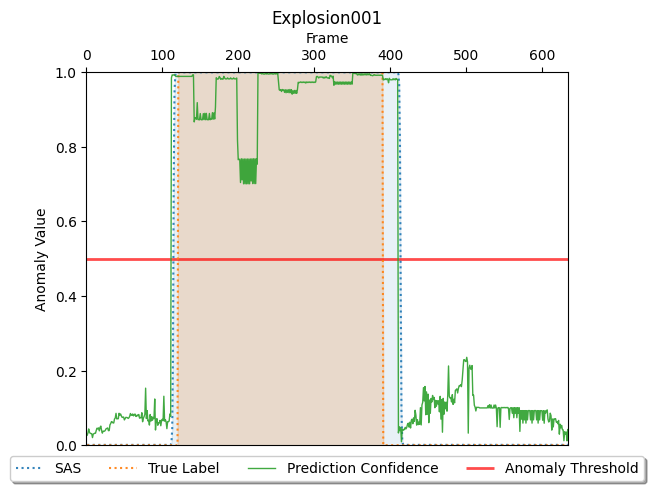

In [ ]:
import matplotlib.pyplot as plt
x  = plot[0]
y1 = plot[1]
y2 = plot[2]
y3 = plot[3]

with plt.style.context("default"):

  fig, axs = plt.subplots(1, 1, constrained_layout=True)

  plt.rcParams['font.size'] = 10
  plt.rcParams['axes.labelsize'] = 10
  plt.rcParams['axes.labelweight'] = 'bold'
  plt.rcParams['xtick.labelsize'] = 8
  plt.rcParams['ytick.labelsize'] = 8
  plt.rcParams['legend.fontsize'] = 10
  plt.rcParams['figure.titlesize'] = 12

  plt.plot(x, y1, label="SAS", linestyle=':', alpha=0.9)
  plt.plot(x, y2, label="True Label", linestyle=':', alpha=0.9)
  plt.plot(x, y3, label="Prediction Confidence", linestyle='-', linewidth=1, alpha=0.9)
  plt.hlines(y=0.5, xmin=0, xmax=plot[0][-1], colors='red', linestyles='-', lw=2, label='Anomaly Threshold', alpha=0.7)
  plt.plot()

  axs.xaxis.set_label_position('top')
  axs.xaxis.tick_top()
  axs.set_xlabel('Frame')
  axs.set_title(video)
  axs.fill_between(x, y2, color='C1', alpha=0.2)
  axs.fill_between(x, y1, color='C0', alpha=0.1)

  plt.ylabel("Anomaly Value")
  plt.xlim([0, plot[0][-1]])
  plt.ylim([0, 1])

  axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),
            fancybox=True, shadow=True, ncol=5)

  plt.savefig(f'img/{video}.png', dpi=900)
  plt.show()